## Análisis de datos - Clase 4

### Tratamiento de outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
# Cargamos el dataset de Titanic de Seaborn
titanic = sns.load_dataset("titanic")[['age', 'fare']].dropna()

# split 80%/20% (sin target definido)
df, test_df = train_test_split(titanic, test_size=0.2, random_state=42)

print(df.shape, test_df.shape)

(571, 2) (143, 2)


In [3]:
df.head(10)

,age,fare
328,31.0,20.5250
73,26.0,14.4542
253,30.0,16.1000
719,33.0,7.7750
666,25.0,13.0000
30,40.0,27.7208
287,22.0,7.8958
217,42.0,27.0000
797,31.0,8.6833
371,18.0,6.4958


In [4]:
df.describe()

,age,fare
count,571.000000,571.000000
mean,30.016935,35.078560
std,14.728887,49.575809
min,0.420000,0.000000
25%,21.000000,8.050000
50%,28.500000,15.750000
75%,39.000000,34.375000
max,80.000000,512.329200


### Detectamos outliers en base al rango intercuartil

Un dato se considera outlier si es < (Q1 - 1.5 * IQR)) o > (Q3 + 1.5 * IQR)

In [5]:
# Métodos estadísticos para detectar outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

IQR = Q3 - Q1
outliers_iqr = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
print(f"Outliers\nAge: <{Q1['age'] - 1.5 * IQR['age']:.02f} o >{Q3['age'] + 1.5 * IQR['age']:.02f}")
print(f"Fare: <{Q1['fare'] - 1.5 * IQR['fare']:.02f} o >{Q3['fare'] + 1.5 * IQR['fare']:.02f}")

Outliers
Age: <-6.00 o >66.00
Fare: <-31.44 o >73.86


### Estrategias de eliminación y tratamiento de outliers

1. Eliminación de outliers
2. Transformación logarítmica para reducir impacto de outliers
3. Imputación con valores estadísticos
4. Segmentación

#### 1. Eliminación de outliers

In [6]:
# Datos con outliers detectados
outliers_detected = df[outliers_iqr.any(axis=1)]
outliers_detected

,age,fare
319,40.00,134.5000
835,39.00,83.1583
291,19.00,91.0792
445,4.00,81.8583
311,18.00,262.3750
...,...,...
393,23.00,113.2750
486,35.00,90.0000
305,0.92,151.5500
645,48.00,76.7292


In [7]:
# 1. Eliminación de outliers
df_no_outliers = df[~outliers_iqr.any(axis=1)]
df_no_outliers.describe()

,age,fare
count,486.000000,486.000000
mean,28.605453,19.426757
std,13.701003,15.168158
min,0.420000,0.000000
25%,20.000000,7.951050
50%,28.000000,13.000000
75%,36.000000,26.250000
max,66.000000,73.500000


#### 2. Transformación logarítmica para reducir impacto de outliers

In [8]:
# 2. Transformación logarítmica para reducir impacto de outliers
df = df.sort_index()
df_transformed = df.copy()
df_transformed['fare'] = np.log1p(df_transformed['fare'])
df_transformed = df_transformed.sort_index()
df_transformed.describe()

,age,fare
count,571.000000,571.000000
mean,30.016935,3.058581
std,14.728887,0.962034
min,0.420000,0.000000
25%,21.000000,2.202765
50%,28.500000,2.818398
75%,39.000000,3.566005
max,80.000000,6.240917


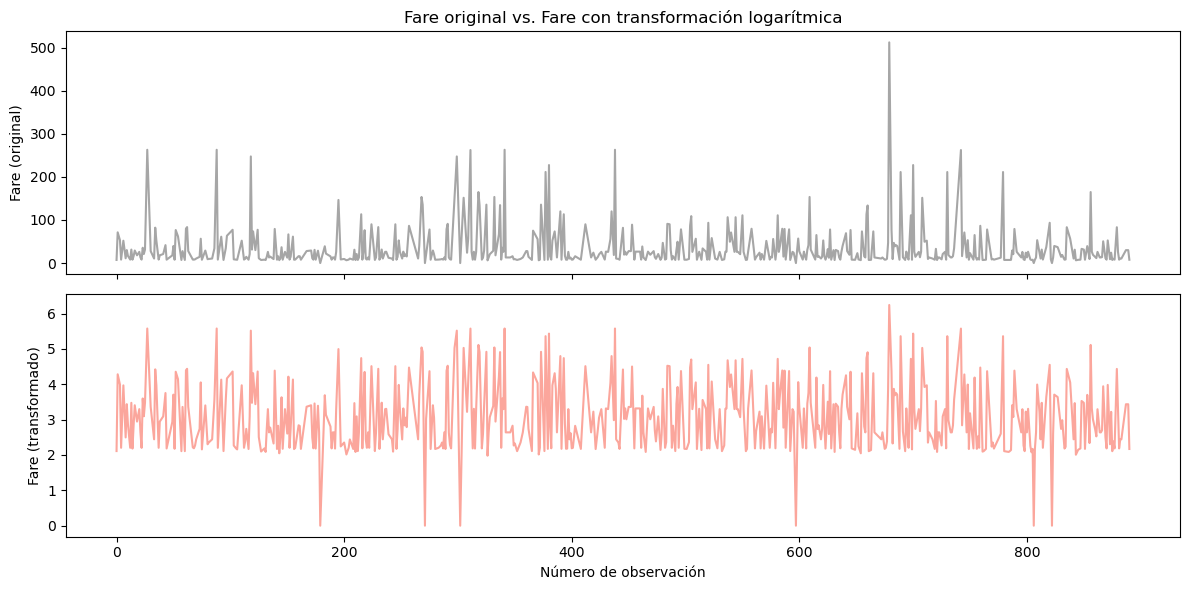

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# Primer gráfico: datos originales
axes[0].plot(df.index, df['fare'], alpha=0.7, color='gray')
axes[0].set_ylabel('Fare (original)')
axes[0].set_title('Fare original vs. Fare con transformación logarítmica')

# Segundo gráfico: datos imputados
axes[1].plot(df_transformed.index, df_transformed['fare'], alpha=0.7, color='salmon')
axes[1].set_ylabel('Fare (transformado)')
axes[1].set_xlabel('Número de observación')

plt.tight_layout()
plt.show()


#### 3. Imputación con valores estadísticos

En este ejemplo imputamos por mediana, pero se puede imputar con otros valores como la moda o la media.

In [10]:
df_imputed = df.copy()
df_imputed.loc[outliers_iqr['fare'], 'fare'] = df['fare'].median()
df_imputed.describe()

,age,fare
count,571.000000,571.000000
mean,30.016935,19.056195
std,14.728887,14.316067
min,0.420000,0.000000
25%,21.000000,8.050000
50%,28.500000,15.750000
75%,39.000000,26.000000
max,80.000000,73.500000


In [11]:
# miro las observaciones que fueron imputadas
df_compara = pd.concat([df['fare'], df_imputed['fare']], axis=1)
df_compara.columns = ['original', 'imputado']
df_compara[df_compara['original']!=df_compara['imputado']]

,original,imputado
27,263.0000,15.75
34,82.1708,15.75
52,76.7292,15.75
61,80.0000,15.75
62,83.4750,15.75
...,...,...
789,79.2000,15.75
820,93.5000,15.75
835,83.1583,15.75
856,164.8667,15.75


#### 4. Segmentación

In [12]:
# Segmentación: Crea una categoría de "outlier" en 'fare'
df_segmented = df.copy()
df_segmented['fare_outlier'] = outliers_iqr['fare'].apply(lambda x: 'Outlier' if x else 'Normal')
df_segmented.sort_values('fare_outlier')

,age,fare,fare_outlier
0,22.0,7.2500,Normal
610,39.0,31.2750,Normal
608,22.0,41.5792,Normal
607,27.0,30.5000,Normal
606,30.0,7.8958,Normal
...,...,...,...
779,43.0,211.3375,Outlier
591,52.0,78.2667,Outlier
337,41.0,134.5000,Outlier
765,51.0,77.9583,Outlier
